## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'fourier'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_fourier_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/fourier/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 45000,
 3: 72000,
 4: 63000,
 5: 117000,
 6: 126000,
 7: 171000,
 8: 189000,
 9: 297000,
 10: 396000,
 11: 495000,
 12: 648000,
 13: 882000,
 14: 1134000,
 15: 1539000,
 16: 1953000,
 17: 2574000,
 18: 3456000,
 19: 4563000,
 20: 5967000,
 21: 8010000,
 22: 10395000,
 23: 13887000,
 24: 18297000,
 25: 24057000,
 26: 31968000,
 27: 42183000,
 28: 55764000,
 29: 73701000,
 30: 97326000,
 31: 108342000,
 32: 59634000,
 33: 21420000}

Running 12760 CDFs


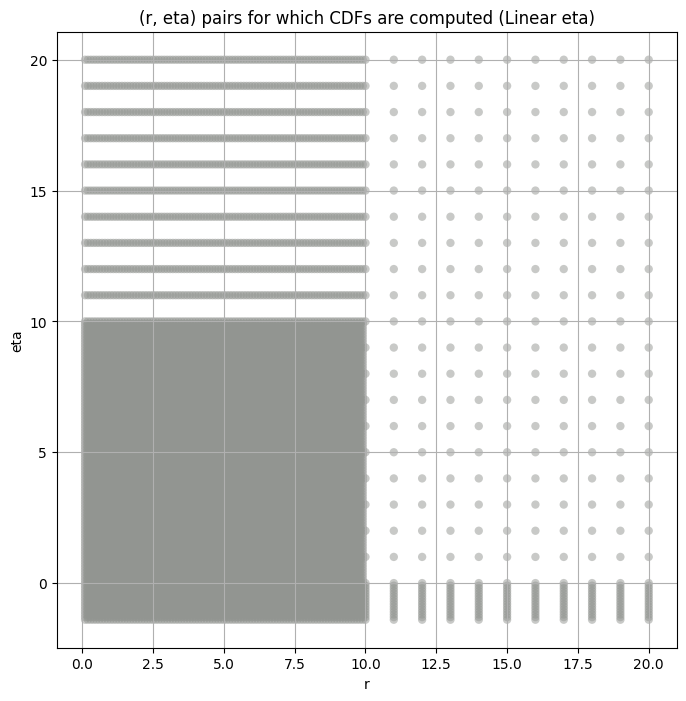

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:44<00:00, 2237.65it/s]


Band 5


100%|██████████| 100000/100000 [00:45<00:00, 2212.25it/s]


Band 8


100%|██████████| 100000/100000 [00:43<00:00, 2293.80it/s]


Band 11


100%|██████████| 100000/100000 [00:47<00:00, 2116.99it/s]


Band 14


100%|██████████| 100000/100000 [00:46<00:00, 2134.20it/s]


Band 17


100%|██████████| 100000/100000 [00:47<00:00, 2114.72it/s]


Band 20


100%|██████████| 100000/100000 [00:46<00:00, 2140.52it/s]


Band 23


100%|██████████| 100000/100000 [00:42<00:00, 2379.93it/s]


Band 26


100%|██████████| 100000/100000 [00:42<00:00, 2348.53it/s]


Band 29


100%|██████████| 100000/100000 [00:46<00:00, 2147.42it/s]


Band 32


100%|██████████| 100000/100000 [00:43<00:00, 2315.08it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,986.118300,606.263600,1555.946500,356.08157,99.133300,600.4443,45000.0
5,583.566700,329.252300,1187.514300,813.59064,103.779990,2060.5480,117000.0
8,195.376500,114.556244,365.574200,612.80610,92.325806,1727.8018,189000.0
11,117.897670,48.120650,487.721070,5769.23900,83.057900,6259.8403,495000.0
14,40.271010,20.443539,131.923110,2610.08280,75.710780,4860.0464,1134000.0
17,24.611858,9.834547,129.458800,11181.92200,65.416466,7685.5044,2574000.0
20,13.320553,5.668727,65.310080,6724.62650,70.291565,6708.6846,5967000.0
23,6.579030,2.254869,43.818960,16738.59000,63.702858,8285.5580,13887000.0
26,3.989165,0.647688,40.324917,32596.10400,71.612460,9318.7330,31968000.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,986.118300,986.118286,527.144897,415.480621,358.278656,321.252411,277.790558,251.658722,232.439148,217.439377,205.033997,177.416779
5,583.566700,583.566711,351.214325,293.240875,257.166168,232.934296,199.840027,178.505127,163.050369,151.395111,142.240265,122.886124
8,195.376500,195.376495,122.219139,103.375656,91.541519,83.230324,72.218895,65.291992,60.323715,56.491871,53.342110,46.568325
11,117.897670,117.897667,50.803547,43.190105,38.718033,35.635345,31.503202,28.783766,26.843023,25.356552,24.163538,21.592682
14,40.271010,40.271011,21.620678,18.509584,16.678082,15.415300,13.764429,12.716779,11.965663,11.392713,10.933157,9.931814
17,24.611858,24.611858,10.372415,8.980819,8.162703,7.598533,6.860110,6.389867,6.054447,5.796036,5.585386,5.120851
20,13.320553,13.320553,6.002163,5.169703,4.677099,4.339134,3.895818,3.610754,3.406793,3.249690,3.121987,2.838699
23,6.579030,6.579030,2.372857,2.062163,1.876152,1.748962,1.581960,1.474000,1.395334,1.333177,1.281515,1.163122
26,3.989165,3.989166,0.683036,0.588150,0.532411,0.494131,0.443637,0.410601,0.386302,0.367093,0.351157,0.314779


####
Band  2


100%|██████████| 12760/12760 [00:24<00:00, 519.01it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.03235493950201604 986.1183


100%|██████████| 12760/12760 [00:19<00:00, 643.08it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.02145777885034815 527.1449


100%|██████████| 12760/12760 [00:20<00:00, 633.24it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.0152476137397497 415.48062


100%|██████████| 12760/12760 [00:19<00:00, 654.47it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.01296538460817627 358.27866


100%|██████████| 12760/12760 [00:19<00:00, 646.62it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.011315230132720927 321.2524


100%|██████████| 12760/12760 [00:19<00:00, 646.57it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.009021084565808968 277.79056


100%|██████████| 12760/12760 [00:19<00:00, 646.78it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.008541632053511439 251.65872


100%|██████████| 12760/12760 [00:19<00:00, 648.32it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.009902724091209958 232.43915


100%|██████████| 12760/12760 [00:19<00:00, 650.75it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.011199996571978899 217.43938


100%|██████████| 12760/12760 [00:19<00:00, 653.23it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.012470721479131197 205.034


100%|██████████| 12760/12760 [00:19<00:00, 643.78it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.01613899605772262 177.41678
Number of samples: 45000, Without approximation : 45000.0


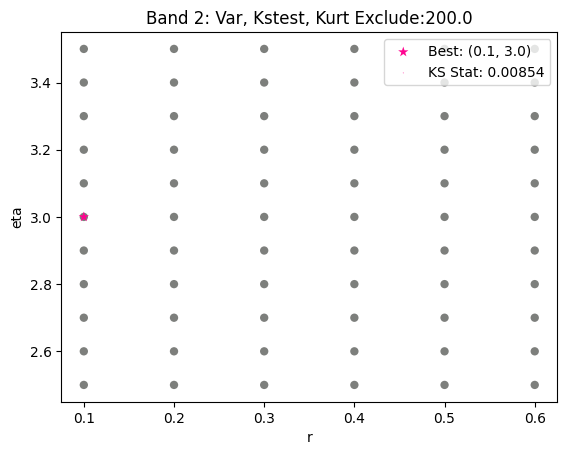

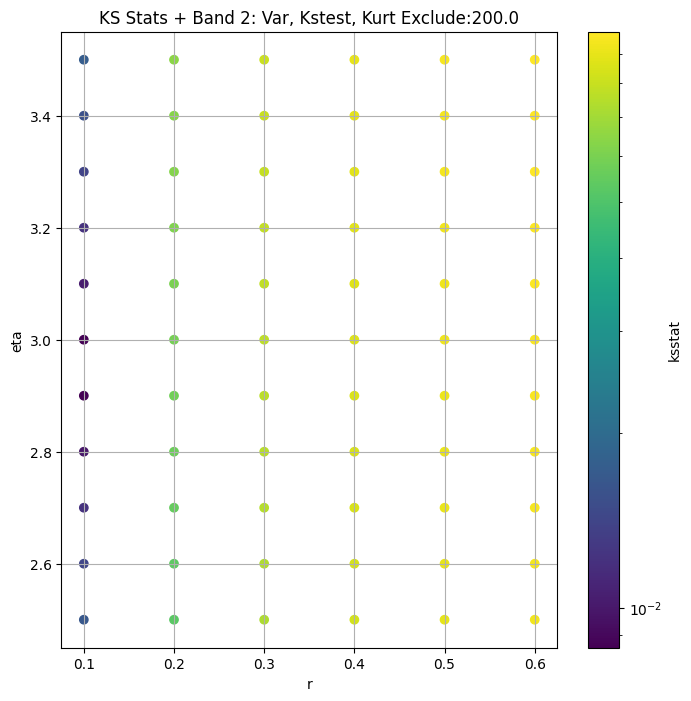

####
Band  5


100%|██████████| 12760/12760 [00:43<00:00, 292.30it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.03424634932466743 583.5667


100%|██████████| 12760/12760 [00:47<00:00, 270.85it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.027443943248597696 351.21432


100%|██████████| 12760/12760 [00:44<00:00, 286.18it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.023382393176389446 293.24088


100%|██████████| 12760/12760 [00:43<00:00, 292.03it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.021040533940100026 257.16617


100%|██████████| 12760/12760 [00:43<00:00, 295.59it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.01770741061539384 232.9343


100%|██████████| 12760/12760 [00:43<00:00, 296.48it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.014894177032902203 199.84003


100%|██████████| 12760/12760 [00:43<00:00, 296.61it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.012723425757424411 178.50513


100%|██████████| 12760/12760 [00:43<00:00, 291.74it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.011352371805699868 163.05037


100%|██████████| 12760/12760 [00:43<00:00, 290.33it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.009598566885301363 151.39511


100%|██████████| 12760/12760 [00:43<00:00, 291.15it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.008446836781226041 142.24026


100%|██████████| 12760/12760 [00:47<00:00, 269.34it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.007594333979055179 122.88612
Number of samples: 100000, Without approximation : 117000.0


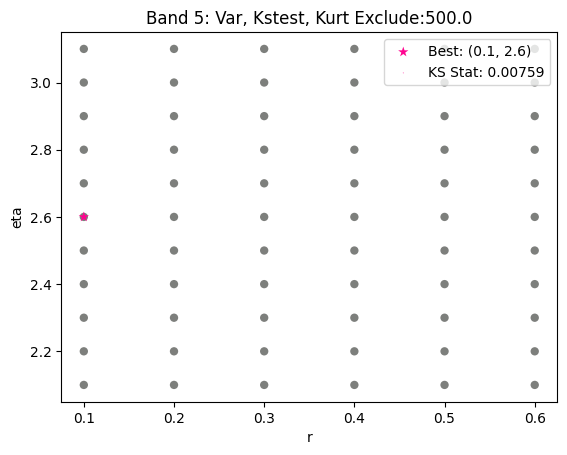

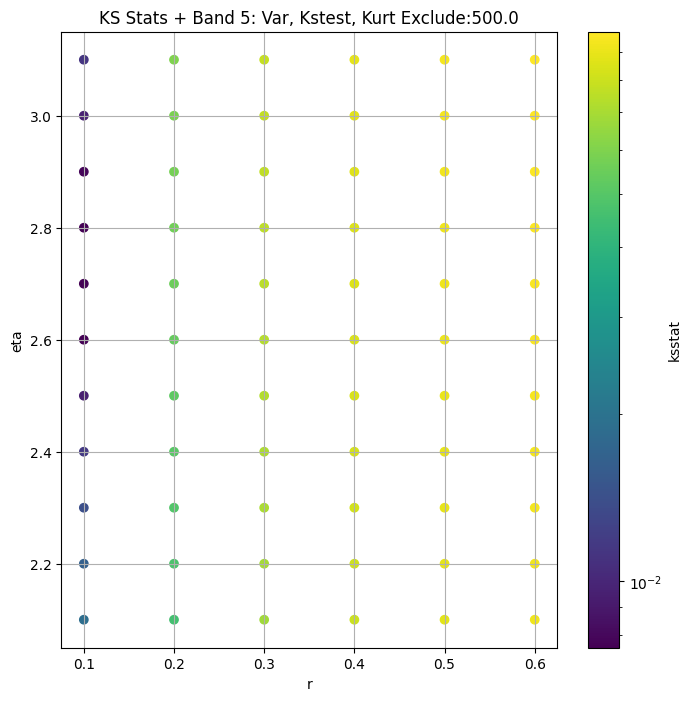

####
Band  8


100%|██████████| 12760/12760 [00:43<00:00, 291.02it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.0346727659803896 195.3765


100%|██████████| 12760/12760 [00:43<00:00, 292.57it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.02573778565679191 122.21914


100%|██████████| 12760/12760 [00:43<00:00, 291.45it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.021935479680492254 103.375656


100%|██████████| 12760/12760 [00:50<00:00, 254.93it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.019734879927719162 91.54152


100%|██████████| 12760/12760 [00:43<00:00, 291.96it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.017522971937010023 83.23032


100%|██████████| 12760/12760 [00:48<00:00, 263.49it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.013740395147783135 72.218895


100%|██████████| 12760/12760 [00:45<00:00, 279.82it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.011572001088099082 65.29199


100%|██████████| 12760/12760 [00:44<00:00, 289.23it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.009260774796289173 60.323715


100%|██████████| 12760/12760 [00:45<00:00, 277.95it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.007976743157146318 56.49187


100%|██████████| 12760/12760 [00:44<00:00, 289.09it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.0066852084886332985 53.34211


100%|██████████| 12760/12760 [00:45<00:00, 281.77it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007328250700508798 46.568325
Number of samples: 100000, Without approximation : 189000.0


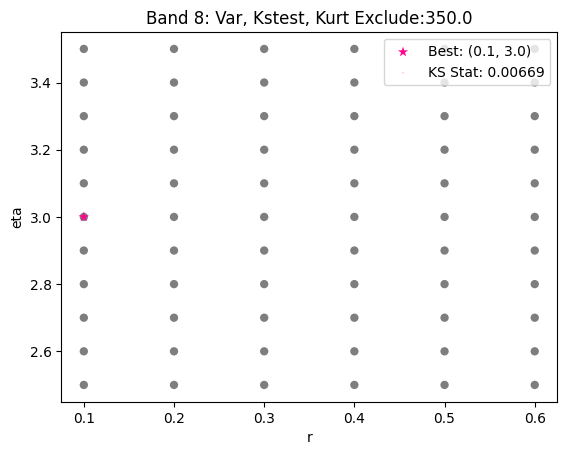

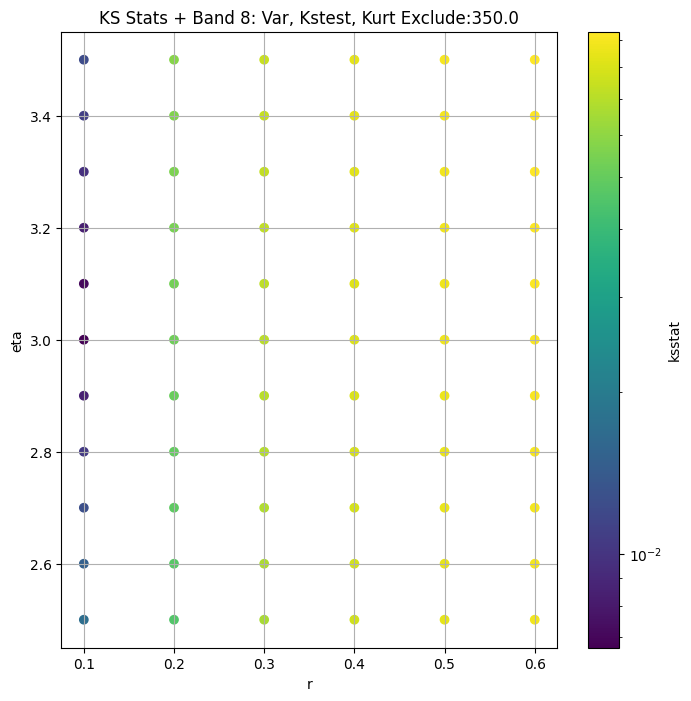

####
Band  11


100%|██████████| 12760/12760 [00:47<00:00, 268.03it/s]


Finding Minimum after computing 12760 CDFs
11 0 0.03691405634574706 117.89767


100%|██████████| 12760/12760 [00:47<00:00, 267.81it/s]


Finding Minimum after computing 12760 CDFs
11 25 0.02120510258012223 50.803547


100%|██████████| 12760/12760 [00:47<00:00, 267.13it/s]


Finding Minimum after computing 12760 CDFs
11 50 0.016728433025059705 43.190105


100%|██████████| 12760/12760 [00:50<00:00, 253.68it/s]


Finding Minimum after computing 12760 CDFs
11 75 0.014353237726832987 38.718033


100%|██████████| 12760/12760 [00:45<00:00, 279.78it/s]


Finding Minimum after computing 12760 CDFs
11 100 0.012768736294212824 35.635345


100%|██████████| 12760/12760 [00:43<00:00, 291.27it/s]


Finding Minimum after computing 12760 CDFs
11 150 0.009211674667709446 31.503202


100%|██████████| 12760/12760 [00:43<00:00, 294.94it/s]


Finding Minimum after computing 12760 CDFs
11 200 0.006856158892682096 28.783766


100%|██████████| 12760/12760 [00:43<00:00, 293.97it/s]


Finding Minimum after computing 12760 CDFs
11 250 0.005212413034151098 26.843023


100%|██████████| 12760/12760 [00:43<00:00, 295.66it/s]


Finding Minimum after computing 12760 CDFs
11 300 0.004431908724089495 25.356552


100%|██████████| 12760/12760 [00:43<00:00, 295.42it/s]


Finding Minimum after computing 12760 CDFs
11 350 0.00496384714804432 24.163538


100%|██████████| 12760/12760 [00:43<00:00, 294.36it/s]


Finding Minimum after computing 12760 CDFs
11 500 0.006782277520536728 21.592682
Number of samples: 100000, Without approximation : 495000.0


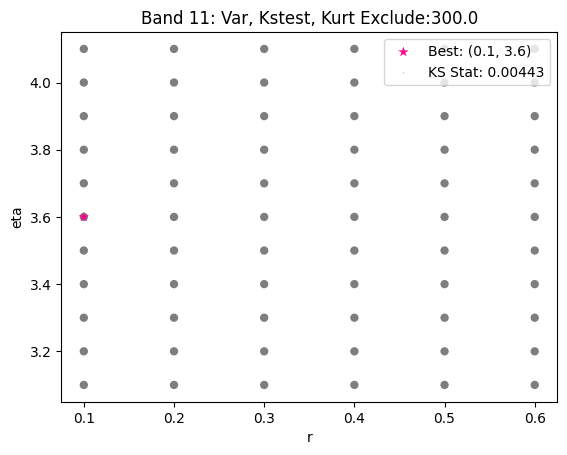

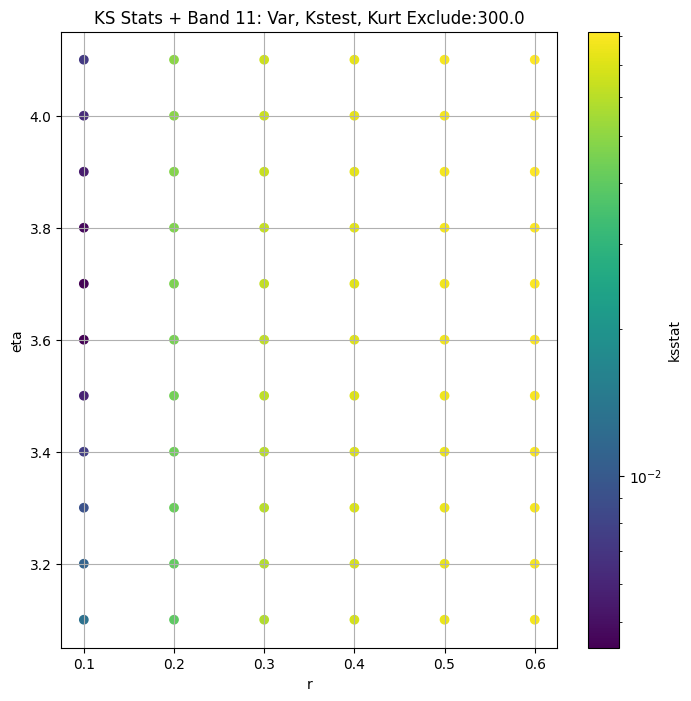

####
Band  14


100%|██████████| 12760/12760 [00:45<00:00, 281.57it/s]


Finding Minimum after computing 12760 CDFs
14 0 0.03128660316636295 40.27101


100%|██████████| 12760/12760 [00:43<00:00, 294.93it/s]


Finding Minimum after computing 12760 CDFs
14 25 0.017877166297839253 21.620678


100%|██████████| 12760/12760 [00:43<00:00, 295.22it/s]


Finding Minimum after computing 12760 CDFs
14 50 0.013884162131634237 18.509584


100%|██████████| 12760/12760 [00:44<00:00, 289.54it/s]


Finding Minimum after computing 12760 CDFs
14 75 0.011024560187635313 16.678082


100%|██████████| 12760/12760 [00:43<00:00, 295.37it/s]


Finding Minimum after computing 12760 CDFs
14 100 0.009287789363129018 15.4153


100%|██████████| 12760/12760 [00:42<00:00, 300.44it/s]


Finding Minimum after computing 12760 CDFs
14 150 0.005735532035053392 13.764429


100%|██████████| 12760/12760 [00:42<00:00, 298.88it/s]


Finding Minimum after computing 12760 CDFs
14 200 0.0036691978407619175 12.716779


100%|██████████| 12760/12760 [00:43<00:00, 295.67it/s]


Finding Minimum after computing 12760 CDFs
14 250 0.003455017346165823 11.965663


100%|██████████| 12760/12760 [00:42<00:00, 300.77it/s]


Finding Minimum after computing 12760 CDFs
14 300 0.003968444776692004 11.392713


100%|██████████| 12760/12760 [00:42<00:00, 299.44it/s]


Finding Minimum after computing 12760 CDFs
14 350 0.004577356263286481 10.933157


100%|██████████| 12760/12760 [00:42<00:00, 299.29it/s]


Finding Minimum after computing 12760 CDFs
14 500 0.006319345345494054 9.931814
Number of samples: 100000, Without approximation : 1134000.0


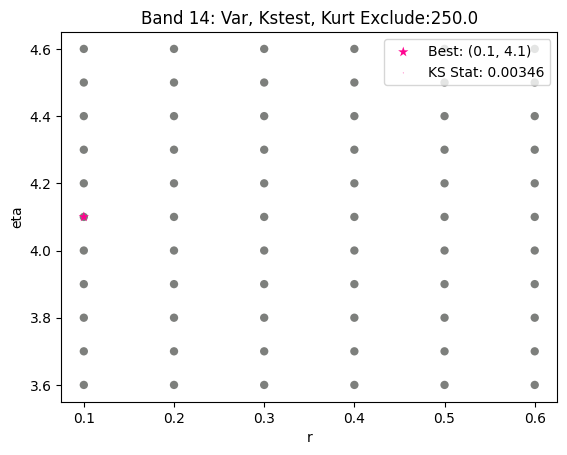

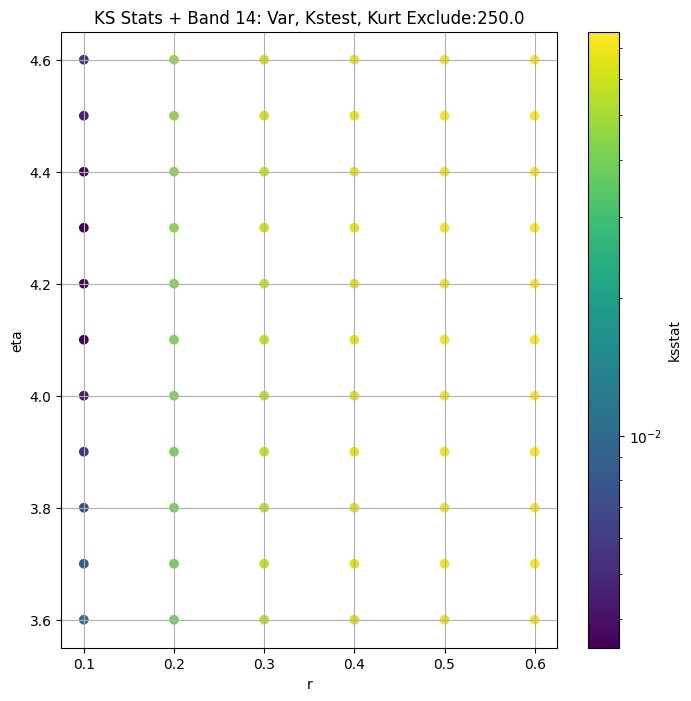

####
Band  17


100%|██████████| 12760/12760 [00:42<00:00, 298.18it/s]


Finding Minimum after computing 12760 CDFs
17 0 0.03272868665513895 24.611858


100%|██████████| 12760/12760 [00:42<00:00, 299.52it/s]


Finding Minimum after computing 12760 CDFs
17 25 0.014110214581181446 10.372415


100%|██████████| 12760/12760 [00:42<00:00, 299.34it/s]


Finding Minimum after computing 12760 CDFs
17 50 0.011005245963468191 8.980819


100%|██████████| 12760/12760 [00:43<00:00, 295.23it/s]


Finding Minimum after computing 12760 CDFs
17 75 0.007960161274847222 8.162703


100%|██████████| 12760/12760 [00:42<00:00, 299.18it/s]


Finding Minimum after computing 12760 CDFs
17 100 0.006136790423246885 7.598533


100%|██████████| 12760/12760 [00:43<00:00, 295.29it/s]


Finding Minimum after computing 12760 CDFs
17 150 0.0037296834318924776 6.86011


100%|██████████| 12760/12760 [00:42<00:00, 299.61it/s]


Finding Minimum after computing 12760 CDFs
17 200 0.002742007742790239 6.389867


100%|██████████| 12760/12760 [00:43<00:00, 296.20it/s]


Finding Minimum after computing 12760 CDFs
17 250 0.0033184769060867142 6.0544467


100%|██████████| 12760/12760 [00:44<00:00, 287.90it/s]


Finding Minimum after computing 12760 CDFs
17 300 0.004006484953259519 5.7960362


100%|██████████| 12760/12760 [00:42<00:00, 298.16it/s]


Finding Minimum after computing 12760 CDFs
17 350 0.004736452044008743 5.585386


100%|██████████| 12760/12760 [00:43<00:00, 291.10it/s]


Finding Minimum after computing 12760 CDFs
17 500 0.006597352145434322 5.1208506
Number of samples: 100000, Without approximation : 2574000.0


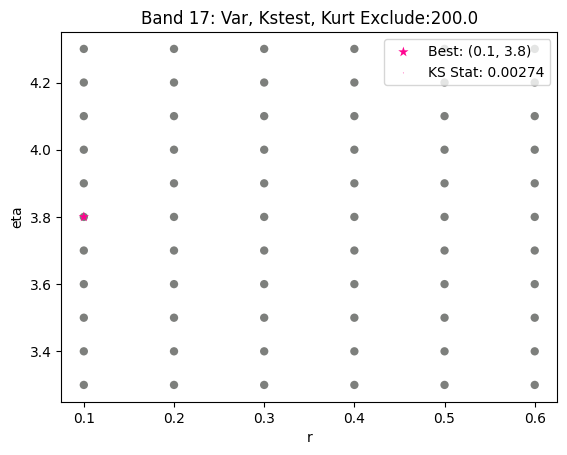

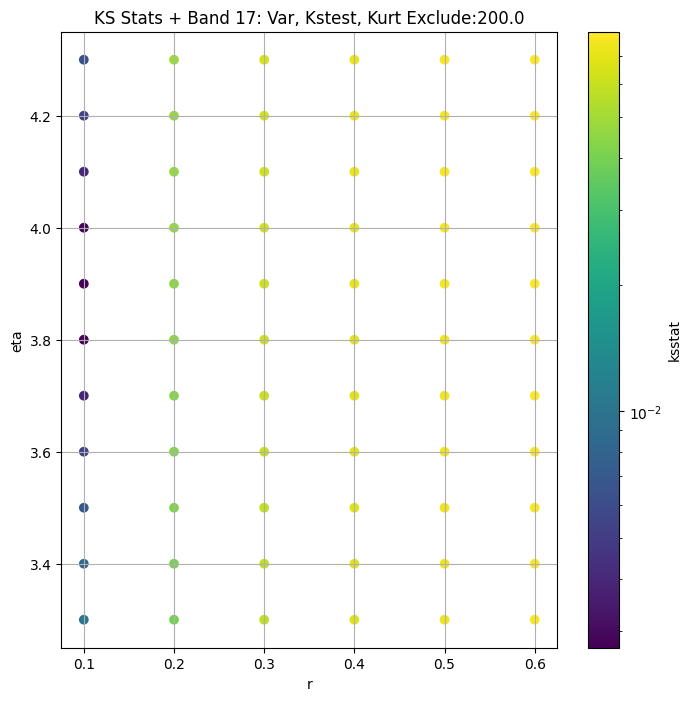

####
Band  20


100%|██████████| 12760/12760 [00:42<00:00, 302.16it/s]


Finding Minimum after computing 12760 CDFs
20 0 0.03033785912321496 13.320553


100%|██████████| 12760/12760 [00:42<00:00, 302.96it/s]


Finding Minimum after computing 12760 CDFs
20 25 0.014791585132339358 6.002163


100%|██████████| 12760/12760 [00:42<00:00, 301.54it/s]


Finding Minimum after computing 12760 CDFs
20 50 0.01149134762261167 5.169703


100%|██████████| 12760/12760 [00:42<00:00, 301.54it/s]


Finding Minimum after computing 12760 CDFs
20 75 0.008990830117100446 4.6770988


100%|██████████| 12760/12760 [00:42<00:00, 300.66it/s]


Finding Minimum after computing 12760 CDFs
20 100 0.007567990615884923 4.3391337


100%|██████████| 12760/12760 [00:42<00:00, 301.85it/s]


Finding Minimum after computing 12760 CDFs
20 150 0.004953025981255577 3.8958185


100%|██████████| 12760/12760 [00:42<00:00, 299.24it/s]


Finding Minimum after computing 12760 CDFs
20 200 0.00344366670656715 3.6107543


100%|██████████| 12760/12760 [00:42<00:00, 301.68it/s]


Finding Minimum after computing 12760 CDFs
20 250 0.003954617816433439 3.4067934


100%|██████████| 12760/12760 [00:42<00:00, 300.30it/s]


Finding Minimum after computing 12760 CDFs
20 300 0.00467752484278805 3.24969


100%|██████████| 12760/12760 [00:42<00:00, 298.89it/s]


Finding Minimum after computing 12760 CDFs
20 350 0.005283454451752871 3.121987


100%|██████████| 12760/12760 [00:43<00:00, 295.01it/s]


Finding Minimum after computing 12760 CDFs
20 500 0.007364596343260754 2.8386989
Number of samples: 100000, Without approximation : 5967000.0


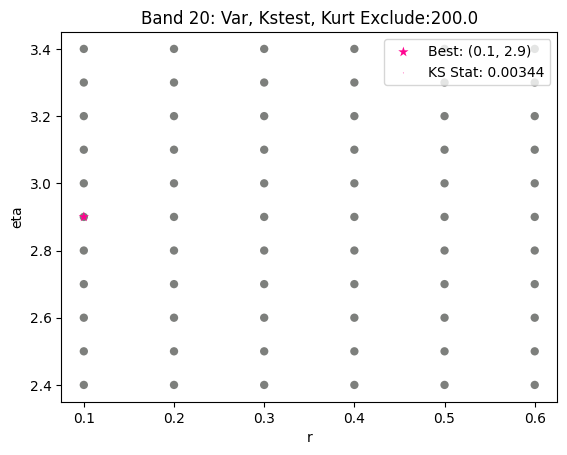

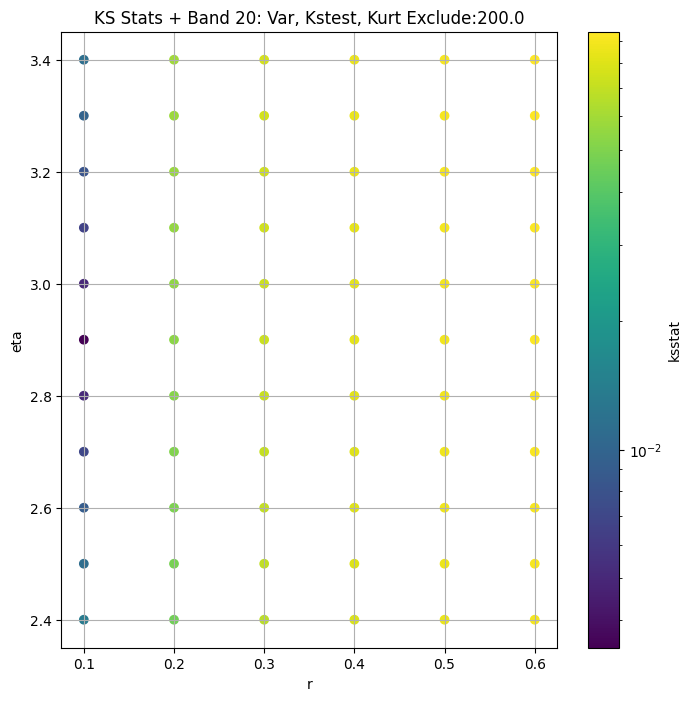

####
Band  23


100%|██████████| 12760/12760 [00:42<00:00, 302.08it/s]


Finding Minimum after computing 12760 CDFs
23 0 0.03408263329103356 6.57903


100%|██████████| 12760/12760 [00:42<00:00, 302.20it/s]


Finding Minimum after computing 12760 CDFs
23 25 0.015095323544165262 2.3728573


100%|██████████| 12760/12760 [00:43<00:00, 294.03it/s]


Finding Minimum after computing 12760 CDFs
23 50 0.01152860232840025 2.0621626


100%|██████████| 12760/12760 [00:43<00:00, 290.05it/s]


Finding Minimum after computing 12760 CDFs
23 75 0.010138039693265655 1.876152


100%|██████████| 12760/12760 [00:42<00:00, 299.63it/s]


Finding Minimum after computing 12760 CDFs
23 100 0.008219164749047492 1.7489616


100%|██████████| 12760/12760 [00:42<00:00, 299.46it/s]


Finding Minimum after computing 12760 CDFs
23 150 0.006435702273924426 1.5819596


100%|██████████| 12760/12760 [00:42<00:00, 300.95it/s]


Finding Minimum after computing 12760 CDFs
23 200 0.005335076864309174 1.4739996


100%|██████████| 12760/12760 [00:43<00:00, 295.17it/s]


Finding Minimum after computing 12760 CDFs
23 250 0.004956416462422286 1.3953336


100%|██████████| 12760/12760 [00:42<00:00, 300.11it/s]


Finding Minimum after computing 12760 CDFs
23 300 0.005892646282362635 1.3331773


100%|██████████| 12760/12760 [00:42<00:00, 302.08it/s]


Finding Minimum after computing 12760 CDFs
23 350 0.00626732058702284 1.2815145


100%|██████████| 12760/12760 [00:45<00:00, 277.83it/s]


Finding Minimum after computing 12760 CDFs
23 500 0.008197869781426115 1.163122
Number of samples: 100000, Without approximation : 13887000.0


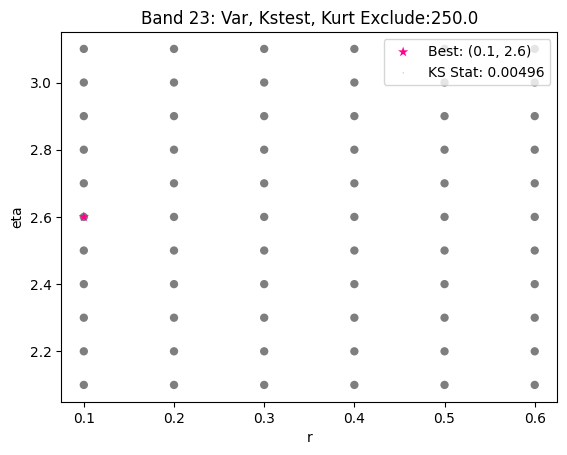

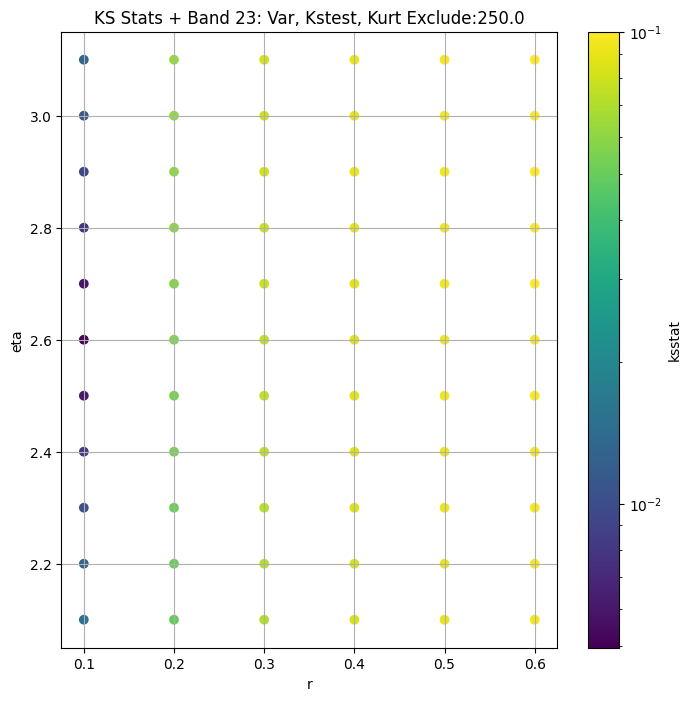

####
Band  26


100%|██████████| 12760/12760 [00:42<00:00, 298.29it/s]


Finding Minimum after computing 12760 CDFs
26 0 0.044727748953985194 3.9891655


100%|██████████| 12760/12760 [09:23<00:00, 22.65it/s]  


Finding Minimum after computing 12760 CDFs
26 25 0.01468849193963162 0.6830364


100%|██████████| 12760/12760 [42:30<00:00,  5.00it/s]  


Finding Minimum after computing 12760 CDFs
26 50 0.011575844180681583 0.5881498


100%|██████████| 12760/12760 [02:25<00:00, 87.80it/s] 


Finding Minimum after computing 12760 CDFs
26 75 0.010883476981032425 0.53241074


100%|██████████| 12760/12760 [01:15<00:00, 169.53it/s]


Finding Minimum after computing 12760 CDFs
26 100 0.008621021634964143 0.49413118


100%|██████████| 12760/12760 [01:16<00:00, 165.80it/s]


Finding Minimum after computing 12760 CDFs
26 150 0.006604710196190577 0.4436373


100%|██████████| 12760/12760 [03:23<00:00, 62.61it/s] 


Finding Minimum after computing 12760 CDFs
26 200 0.005948530229098248 0.41060108


100%|██████████| 12760/12760 [02:47<00:00, 76.23it/s] 


Finding Minimum after computing 12760 CDFs
26 250 0.0055038034929381086 0.38630214


100%|██████████| 12760/12760 [02:39<00:00, 80.05it/s] 


Finding Minimum after computing 12760 CDFs
26 300 0.006452368465045821 0.36709252


100%|██████████| 12760/12760 [02:56<00:00, 72.44it/s] 


Finding Minimum after computing 12760 CDFs
26 350 0.006596038430072504 0.35115704


100%|██████████| 12760/12760 [01:42<00:00, 123.96it/s]


Finding Minimum after computing 12760 CDFs
26 500 0.008453416423319315 0.31477895
Number of samples: 100000, Without approximation : 31968000.0


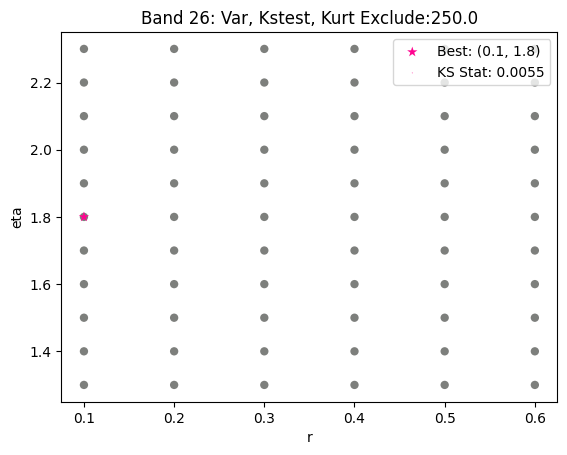

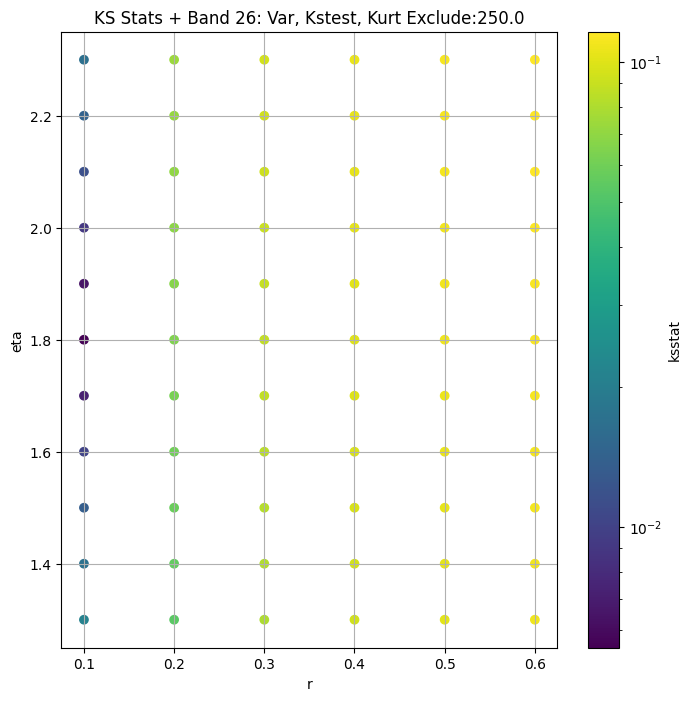

####
Band  29


100%|██████████| 12760/12760 [01:12<00:00, 175.99it/s]


Finding Minimum after computing 12760 CDFs
29 0 0.04241956678215392 0.42680618


 56%|█████▌    | 7141/12760 [16:40<27:26:17, 17.58s/it]

In [ ]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [ ]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/621 [00:00<?, ?it/s]

100%|██████████| 621/621 [00:01<00:00, 330.51it/s]


Finding Minimum after computing 621 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.006446654146372063, var: 9.18262767791748


100%|██████████| 621/621 [00:01<00:00, 336.42it/s]


Finding Minimum after computing 621 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.005556268473133966, var: 9.35315227508545


100%|██████████| 621/621 [00:03<00:00, 202.75it/s]


Finding Minimum after computing 621 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.0047517857864224355, var: 9.546412467956543


100%|██████████| 621/621 [00:01<00:00, 359.43it/s]


Finding Minimum after computing 621 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.003902993213333414, var: 9.782848358154297


100%|██████████| 621/621 [00:02<00:00, 287.15it/s]


Finding Minimum after computing 621 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.0034661060093266194, var: 10.134422302246094
Number of samples: 31800, Without approximation : 31800.0


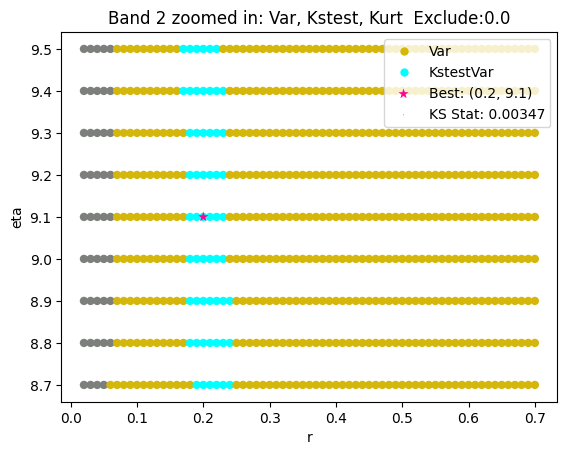

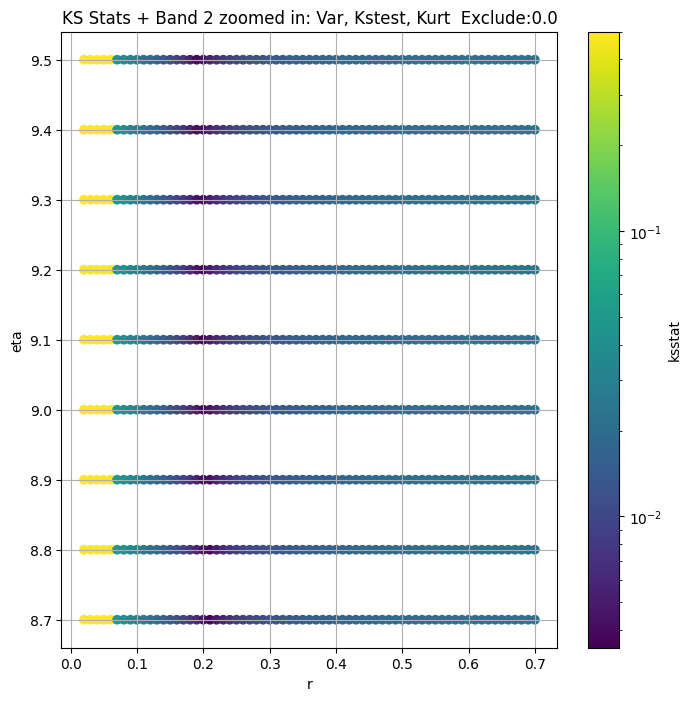

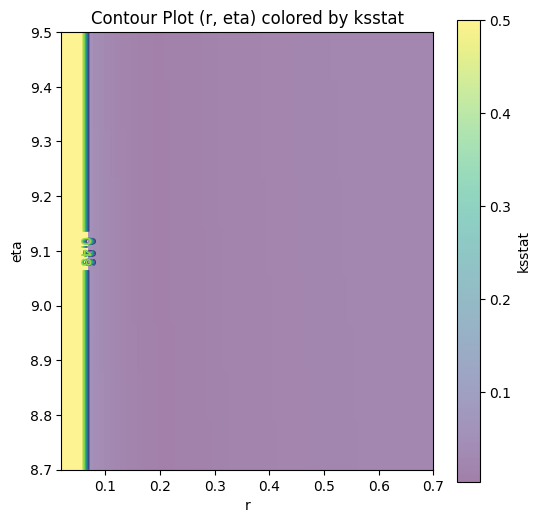

Band 5


0it [00:00, ?it/s]

Finding Minimum after computing 0 CDFs


ValueError: attempt to get argmin of an empty sequence

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

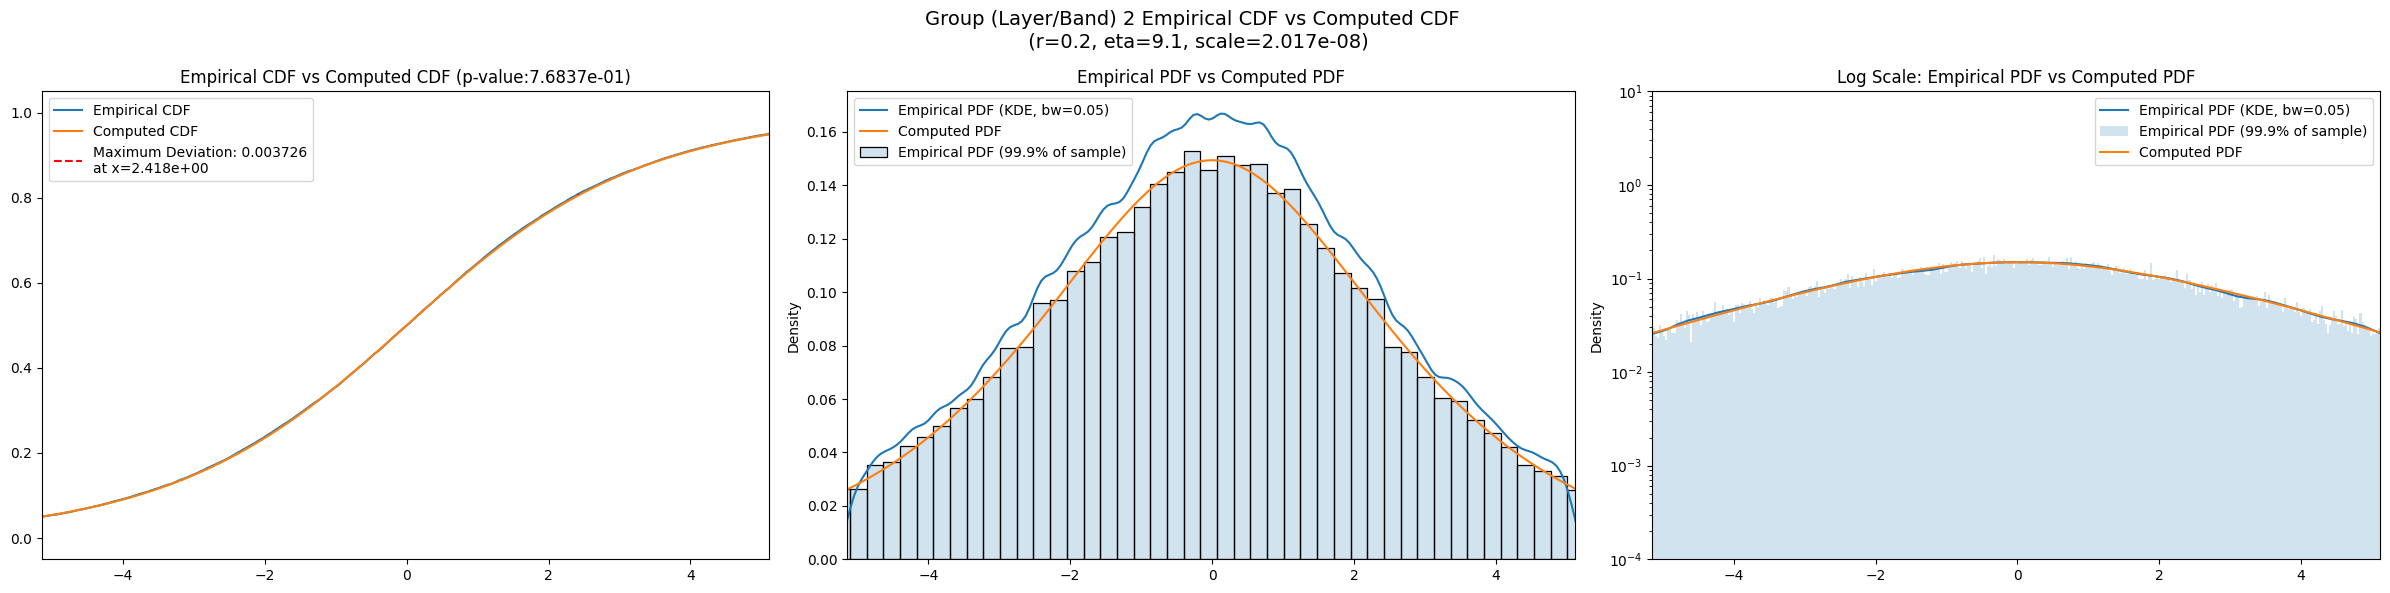

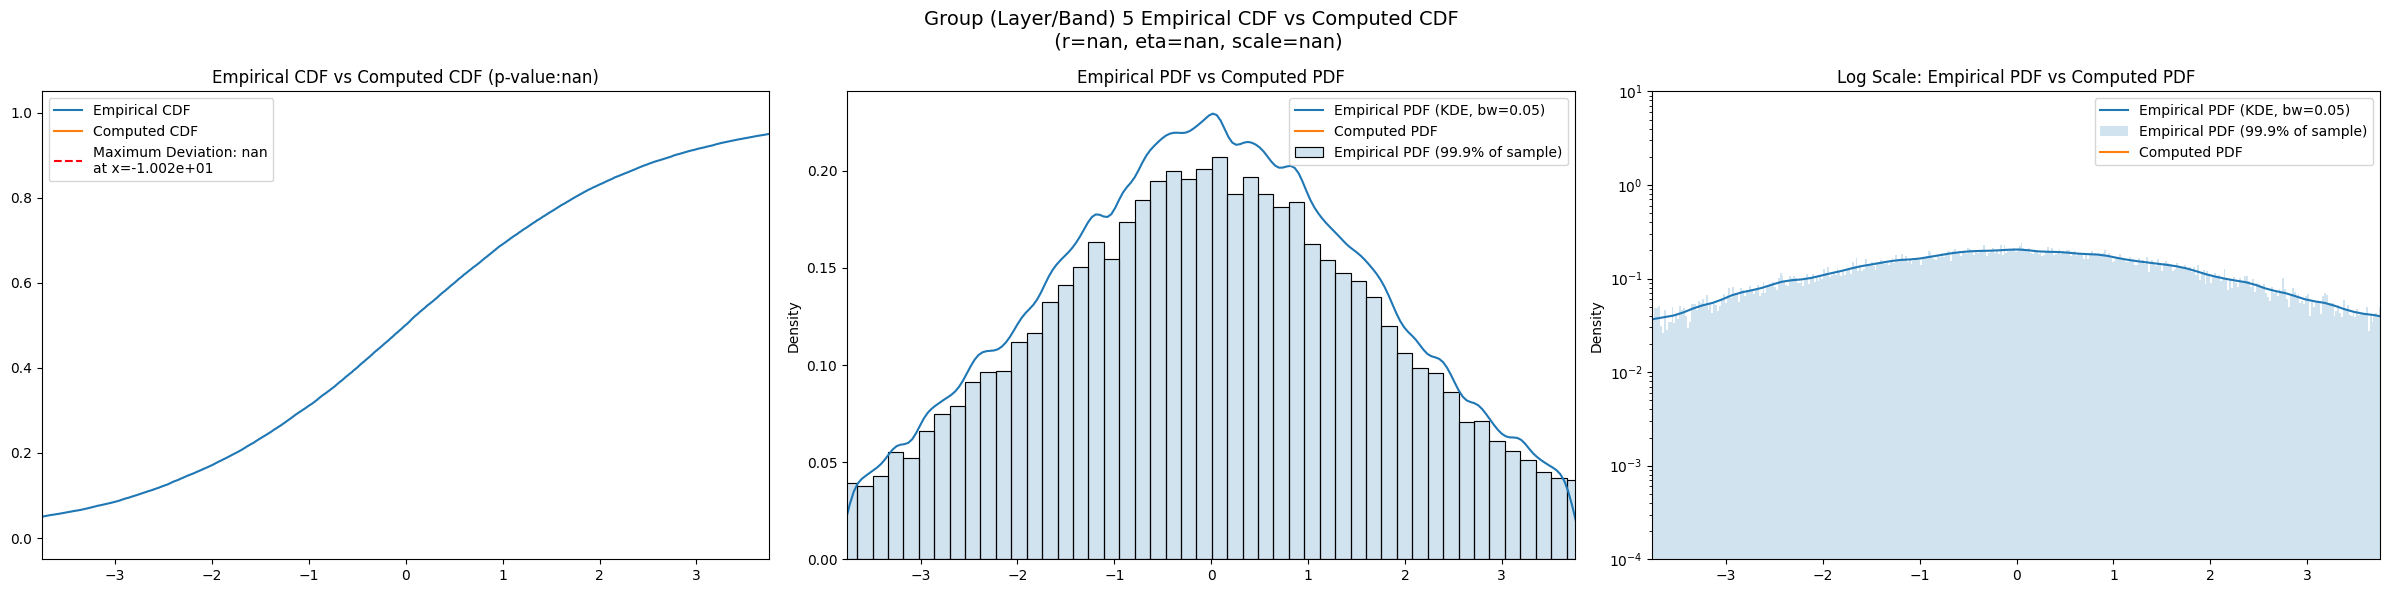

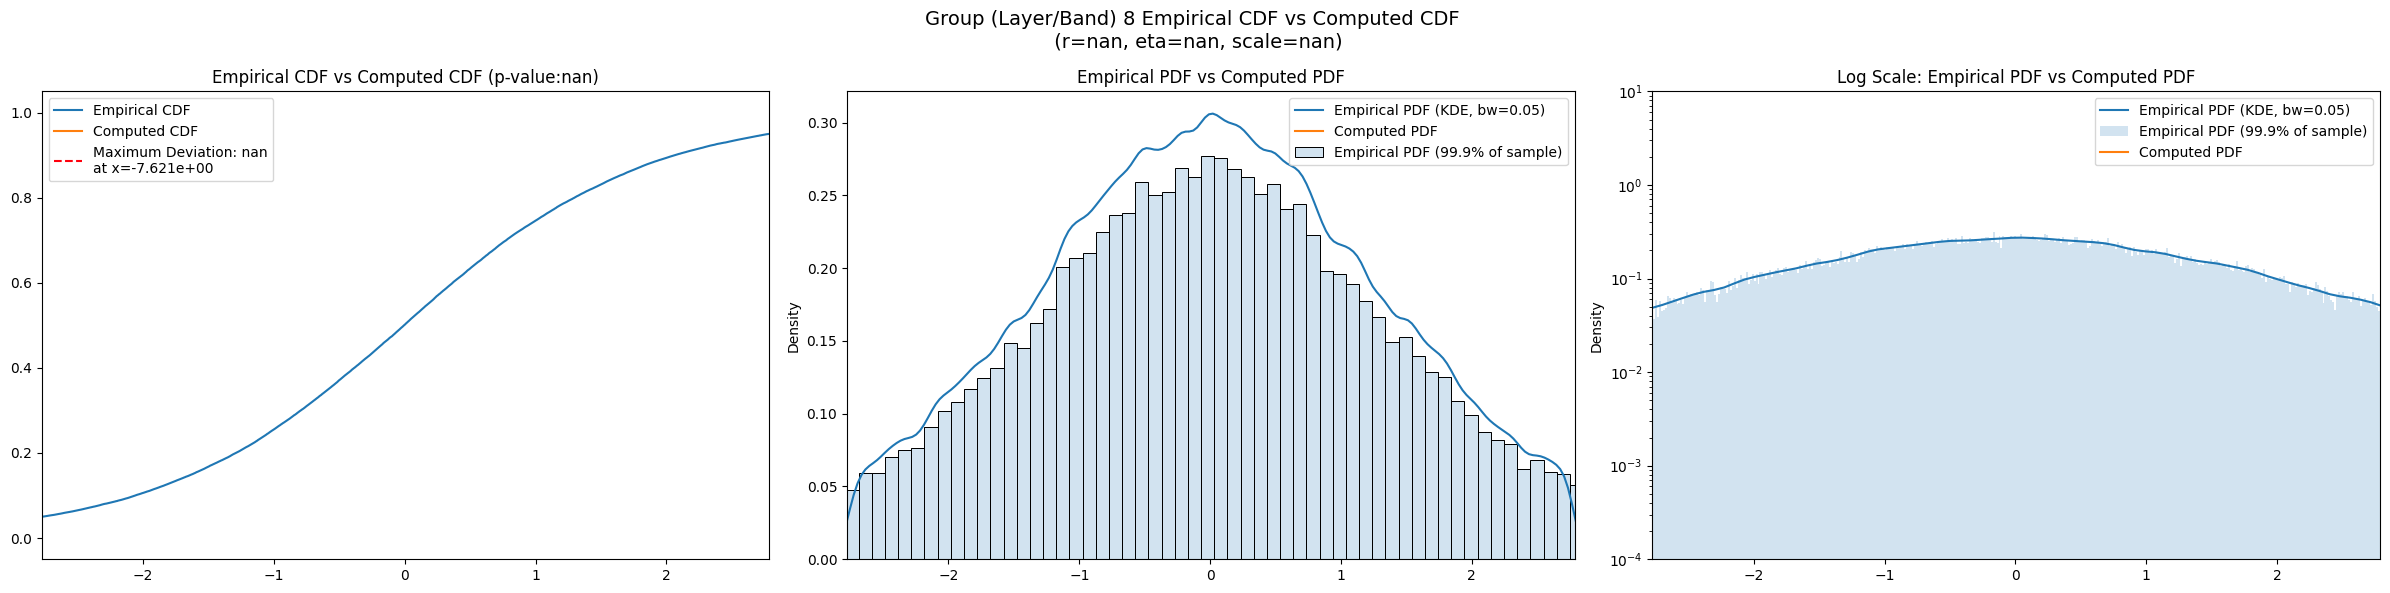

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/CSVs/master_df.csv'

In [ ]:
master_df.filter(regex="kstest_stat.*")

In [ ]:
master_df.filter(regex="best.*")

In [ ]:
eng.quit()